In [4]:
import re
import pandas as pd
from typing import  Literal,List,Any
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.types import Command
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict, Annotated
from langchain_core.prompts.chat import ChatPromptTemplate
from langgraph.graph import START, StateGraph,END
from langgraph.prebuilt import create_react_agent
from pydantic import BaseModel, Field, field_validator
from langchain_core.messages import HumanMessage,AIMessage
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

In [5]:
# import os
# groq_api_key = os.getenv("GROQ_API_KEY")  # ENV variable se le raha hai

# groq_model = ChatGroq(
#     model="deepseek-r1-distill-llama-70b",
#     api_key=groq_api_key  # Secure API key usage
# )

load_dotenv()

True

In [ ]:
import os
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"]=OPENAI_API_KEY

data_path = r"C:\Users\ganes\DataScience\Gen_AI\LangChain\Course_GenAI\Gen_AI_In-Depth\Projects\multiagent_apoointment_doctor\data\doctor_availability.csv"

In [26]:
df = pd.read_csv(data_path)
df.head()

,date_slot,specialization,doctor_name,is_available,patient_to_attend
0,05-08-2024 08:00,general_dentist,john doe,True,NaN
1,05-08-2024 08:30,general_dentist,john doe,False,1000082.0
2,05-08-2024 09:00,general_dentist,john doe,False,1000048.0
3,05-08-2024 09:30,general_dentist,john doe,False,1000036.0
4,05-08-2024 10:00,general_dentist,john doe,False,1000024.0


In [7]:
import ollama

response = ollama.chat(
    model='llama3',
    messages=[
        {"role": "user", "content": "Hello! How are you?"}
    ]
)

print(response['message']['content'])

I'm just an AI, so I don't have emotions or feelings like humans do. However, I'm functioning properly and ready to assist with any questions or tasks you may have. It's great to chat with you! What brings you here today?


In [8]:
# openai_model=ChatOpenAI(model="gpt-4o")
# openai_model.invoke("hi")

from langchain_ollama import ChatOllama
ollama_model = ChatOllama(model="llama3")

llm = ollama_model.invoke("Hi, how are you?")
print(llm.content)

I'm just an AI, so I don't have feelings or emotions like humans do. However, I'm functioning properly and ready to assist with any questions or tasks you may have! How can I help you today?


In [12]:
# This model is for validating date and time in the format 'DD-MM-YYYY HH:MM'
class DateTimeModel(BaseModel):
    date: str = Field(description="Properly formatted date", pattern=r'^\d{2}-\d{2}-\d{4} \d{2}:\d{2}$')

    @field_validator("date")
    def check_format_date(cls, v):
        if not re.match(r'^\d{2}-\d{2}-\d{4} \d{2}:\d{2}$', v):  # Ensures 'DD-MM-YYYY HH:MM' format
            raise ValueError("The date should be in format 'DD-MM-YYYY HH:MM'")
        return v

In [13]:
# This model is for validating date input in the 'DD-MM-YYYY' format.
class DateModel(BaseModel):
    date: str = Field(description="Properly formatted date", pattern=r'^\d{2}-\d{2}-\d{4}$')

    @field_validator("date")
    def check_format_date(cls, v):
        if not re.match(r'^\d{2}-\d{2}-\d{4}$', v):  # Ensures DD-MM-YYYY format
            raise ValueError("The date must be in the format 'DD-MM-YYYY'")
        return v

In [14]:
# validating that the ID number is 7 or 8 digits long.
class IdentificationNumberModel(BaseModel):
    id: int = Field(description="Identification number (7 or 8 digits long)")
    @field_validator("id")
    def check_format_id(cls, v):
        if not re.match(r'^\d{7,8}$', str(v)):  # Convert to string before matching
            raise ValueError("The ID number should be a 7 or 8-digit number")
        return v

In [15]:
df = pd.read_csv(data_path)
df.head()

,date_slot,specialization,doctor_name,is_available,patient_to_attend
0,05-08-2024 08:00,general_dentist,john doe,True,NaN
1,05-08-2024 08:30,general_dentist,john doe,False,1000082.0
2,05-08-2024 09:00,general_dentist,john doe,False,1000048.0
3,05-08-2024 09:30,general_dentist,john doe,False,1000036.0
4,05-08-2024 10:00,general_dentist,john doe,False,1000024.0


In [22]:
# This tool checks available time slots for a specific doctor on a given date.
@tool
def check_availability_by_doctor(desired_date:DateModel, doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']):
    """
    Checking the database if we have availability for the specific doctor.
    The parameters should be mentioned by the user in the query
    """
    df = pd.read_csv(data_path)
    
    #print(df)

    # extracts the time part from the 'date_slot' column (which contains both date and time as a single string like '15-04-2025 14:30') 
    # and stores it in a new column called 'date_slot_time' = '14:30'
    df['date_slot_time'] = df['date_slot'].apply(lambda input: input.split(' ')[-1])
    # print(df)
    
    rows = list(df[ # Converts the result into a list of time strings
    (df['date_slot'].apply(lambda input: input.split(' ')[0]) == desired_date.date) & # Extracts date part from date_slot column (e.g., '15-04-2025') and checks if it matches the desired_date(inpuut date)
    (df['doctor_name'] == doctor_name) & # Checks if the doctor matches the requested doctor(input doctor)
    (df['is_available'] == True) # Checks if the slot is marked as available i.e True
    ]['date_slot_time']) #  Selects the corresponding time part of the matching rows

    if len(rows) == 0:
        output = "No availability in the entire day"
    else:
        output = f'The availability for {desired_date.date}\n' # The availability for 15-04-2025
        output += "Available slots: " + ', '.join(rows) # Available slots: 09:00, 14:30, 16:00

    return output # a list of available time slots for a given doctor on a given date

In [23]:
# Example usage:
date_instance = DateModel(date="03-09-2024")
print(date_instance)

date='03-09-2024'


In [24]:
print(check_availability_by_doctor.invoke({"desired_date": date_instance, "doctor_name": "kevin anderson"}))

The availability for 03-09-2024
Available slots: 08:00, 08:30, 11:30, 12:00, 12:30, 13:00, 14:00, 14:30, 15:00, 15:30, 16:00, 16:30


In [ ]:
@tool
def check_availability_by_specialization(desired_date:DateModel, specialization:Literal["general_dentist", "cosmetic_dentist", "prosthodontist", "pediatric_dentist","emergency_dentist","oral_surgeon","orthodontist"]):
    """
    Checking the database if we have availability for the specific specialization.
    The parameters should be mentioned by the user in the query
    """
    #Dummy data
    df = pd.read_csv(data_path)
    df['date_slot_time'] = df['date_slot'].apply(lambda input: input.split(' ')[-1])

    rows = df[ # row = ["orthodontist", "Dr. Emily", ["09:00", "14:30"]]
        (df['date_slot'].apply(lambda input: input.split(' ')[0]) == desired_date.date) & # Extracts date part from date_slot column (e.g., '15-04-2025') and checks if it matches the desired_date(inpuut date)
        (df['specialization'] == specialization) & # Checks if the specialization matches the requested spcialization(input specialization)
        (df['is_available'] == True) # Checks if the slot is marked as available i.e True
        ].groupby(['specialization', 'doctor_name'])['date_slot_time'].apply(list).reset_index(name='available_slots')
    #  groups the data by specialization and doctor_name and collects available time slots (date_slot_time) and aggregates into list

    if len(rows) == 0:
        output = "No availability in the entire day"
    else:
        def convert_to_am_pm(time_str):
            # Split the time string into hours and minutes
            time_str = str(time_str)

            # time_str.split(":") Example: "14:30" → ["14", "30"] → convert to int[14, 30] and assing to hours(14) and minutes(30)
            hours, minutes = map(int, time_str.split(":"))
            # map() = It takes a function(int) and a sequence of values(time_str.split(":")), applies the function to each item in the sequence, and returns a map object
            
            # Determine AM or PM
            period = "AM" if hours < 12 else "PM" # 00:00 to 11:59 → AM &&  12:00 to 23:59 → PM
            
            # Convert hours to 12-hour format
            hours = hours % 12 or 12
            
            # Format the output
            return f"{hours}:{minutes:02d} {period}" # 8:30 AM   hours(8):minutes(30) period(AM)
        output = f'This availability for {desired_date.date}\n'
        for row in rows.values: # row[1]: The doctor's name. row[2]: available time slots (like ["09:00", "14:30"])
            output += row[1] + ". Available slots: \n" + ', \n'.join([convert_to_am_pm(value)for value in row[2]])+'\n' # "Dr. Emily. Available slots: \n09:00 AM, \n2:30 PM\n"

    return output

In [54]:
# Example usage:
date_instance = DateModel(date="03-09-2024")
print(date_instance)

date='03-09-2024'


In [55]:
print(check_availability_by_specialization.invoke({"desired_date": date_instance, "specialization": "orthodontist"}))

This availability for 03-09-2024
kevin anderson. Available slots: 
8:00 AM, 
8:30 AM, 
11:30 AM, 
12:00 PM, 
12:30 PM, 
1:00 PM, 
2:00 PM, 
2:30 PM, 
3:00 PM, 
3:30 PM, 
4:00 PM, 
4:30 PM



In [25]:
df.head()

,date_slot,specialization,doctor_name,is_available,patient_to_attend
0,05-08-2024 08:00,general_dentist,john doe,True,NaN
1,05-08-2024 08:30,general_dentist,john doe,False,1000082.0
2,05-08-2024 09:00,general_dentist,john doe,False,1000048.0
3,05-08-2024 09:30,general_dentist,john doe,False,1000036.0
4,05-08-2024 10:00,general_dentist,john doe,False,1000024.0


In [ ]:
## Tools For Booking agent
@tool
def reschedule_appointment(old_date:DateTimeModel, new_date:DateTimeModel, id_number:IdentificationNumberModel, doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']):
    """
    Rescheduling an appointment.
    The parameters MUST be mentioned by the user in the query.
    """
    #Dummy data
    df = pd.read_csv(data_path)
    available_for_desired_date = df[
    (df['date_slot'] == new_date.date) & # Checks if the date and time match exactly with the user’s requested new_date
    (df['is_available'] == True) & #  Ensures the slot is actually available.
    (df['doctor_name'] == doctor_name) # Matches the specific doctor requested.
]
    if len(available_for_desired_date) == 0:
        return "Not available slots in the desired period"
    else:
        cancel_appointment.invoke({'date':old_date, 'id_number':id_number, 'doctor_name':doctor_name}) # Cancel the old appointment for the same id_number (patient).
        set_appointment.invoke({'desired_date':new_date, 'id_number': id_number, 'doctor_name': doctor_name}) # Book a new appointment with the same id_number, but at the new desired time and date.
        return "Successfully rescheduled for the desired time"

In [57]:
Old_Date_Time = DateTimeModel(date="05-08-2024 08:30")
Old_Date_Time

DateTimeModel(date='05-08-2024 08:30')

In [58]:
New_Date_Time = DateTimeModel(date="28-03-2024 14:30")
New_Date_Time

DateTimeModel(date='28-03-2024 14:30')

In [59]:
IDNumber = IdentificationNumberModel(id=1000082)
IDNumber

IdentificationNumberModel(id=1000082)

In [60]:
print(reschedule_appointment.invoke({"old_date": Old_Date_Time,"new_date": New_Date_Time,"id_number":IDNumber, "doctor_name": "kevin anderson"}))

Not available slots in the desired period


In [ ]:
@tool
def cancel_appointment(date:DateTimeModel, id_number:IdentificationNumberModel, doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']):
    """
    Canceling an appointment.
    The parameters MUST be mentioned by the user in the query.
    """
    df = pd.read_csv(data_path)
    case_to_remove = df[ # Find the appointment for this patient, with this doctor, at this exact date and time.
    (df['date_slot'] == date.date) &                    # The appointment date and time matches the given date
    (df['patient_to_attend'] == id_number.id) &         # The appointment is for the patient with the given ID
    (df['doctor_name'] == doctor_name)                  # The appointment is with the specified doctor
]
    if len(case_to_remove) == 0:
        return "You don´t have any appointment with that specifications"
    else:
        df.loc[ # Finds the exact appointment row using the date & time, the patient's ID and the doctor’s name
    (df['date_slot'] == date.date) & 
    (df['patient_to_attend'] == id_number.id) & 
    (df['doctor_name'] == doctor_name), 
    ['is_available', 'patient_to_attend'] # Updates two columns for that row 
] = [True, None] # is_available → True → Marks the time slot as free and patient_to_attend → None → Removes the patient from that slot.
        df.to_csv(data_path, index = False)

        return "Successfully cancelled"

In [62]:
Date = DateTimeModel(date="07-08-2024 08:30")
Date

DateTimeModel(date='07-08-2024 08:30')

In [63]:
IDNumber = IdentificationNumberModel(id=1000097)
IDNumber

IdentificationNumberModel(id=1000097)

In [64]:
print(cancel_appointment.invoke({"date": Date,"id_number":IDNumber,"doctor_name":"john doe"}))

You don´t have any appointment with that specifications


In [ ]:
@tool
def set_appointment(desired_date:DateTimeModel, id_number:IdentificationNumberModel, doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']):
    """
    Set appointment or slot with the doctor.
    The parameters MUST be mentioned by the user in the query.
    """
    df = pd.read_csv(data_path)
   
    from datetime import datetime
    def convert_datetime_format(dt_str):
        # Parse the input datetime string
        #dt = datetime.strptime(dt_str, "%Y-%m-%d %H:%M")
        dt = datetime.strptime(dt_str, "%d-%m-%Y %H:%M")
        
        # Format the output as 'DD-MM-YYYY H.M' (removing leading zero from hour only)
        return dt.strftime("%d-%m-%Y %#H.%M")
    
    case = df[(df['date_slot'] == convert_datetime_format(desired_date.date)) & # date_slot column in the DataFrame matches the desired date
        (df['doctor_name'] == doctor_name) & # doctor_name matches the provided doctor_name
        (df['is_available'] == True)] # only selecting rows where the is_available column is True
    
    if len(case) == 0:
        return "No available appointments for that particular case"
    else:
        df.loc[(df['date_slot'] == convert_datetime_format(desired_date.date)) & # find rows where the date_slot column matches the desired date
                (df['doctor_name'] == doctor_name) & #  filters the rows to match the specified doctor_name
                (df['is_available'] == True), ['is_available', 'patient_to_attend']] = [False, id_number.id]
                # only rows where the doctor is available (i.e., is_available is True) are selected
                # False will be assigned to the is_available column, marking the slot as unavailable
                # id_number.id will be assigned to the patient_to_attend column, indicating the ID of the patient who is now scheduled for the appointment

        df.to_csv(data_path, index = False)

        return "Succesfully done"

In [66]:
Date = DateTimeModel(date="07-08-2024 08:30")
Date

DateTimeModel(date='07-08-2024 08:30')

In [67]:
IDNumber = IdentificationNumberModel(id=1000097)
IDNumber    

IdentificationNumberModel(id=1000097)

In [68]:
print(set_appointment.invoke({"desired_date":Date,"id_number":IDNumber,"doctor_name":"john doe"}))

No available appointments for that particular case


In [ ]:
# defines a class called Router that inherits from TypedDict
class Router(TypedDict): # TypedDict is used to define a dictionary with a fixed set of keys, each having a specific type. It helps to describe a dictionary with predefined keys and their corresponding value types
    next: Literal["information_node","booking_node","FINISH"] # The value must be one of the following: "information_node", "booking_node", or "FINISH".
    reasoning: str # the value must be string

In [ ]:
class AgentState(TypedDict):
    messages: Annotated[list[Any], add_messages] # stores a list of messages and  any contains the full chat history, including user query and add_messages  provide additional metadata or behavior for how messages are handled
    id_number: int
    next:str
    query: str # stores just the extracted user query text (as a plain string)
    current_reasoning: str

In [71]:
members_dict = {'information_node':'specialized agent to provide information related to availability of doctors or any FAQs related to hospital.','booking_node':'specialized agent to only to book, cancel or reschedule appointment'}
members_dict

{'information_node': 'specialized agent to provide information related to availability of doctors or any FAQs related to hospital.',
 'booking_node': 'specialized agent to only to book, cancel or reschedule appointment'}

In [ ]:
# accesses the keys of the members_dict dictionary and  concatenates the list of keys  with a new list containing the string "FINISH"
# members_dict = {"a": 1, "b": 2, "c": 3}
# output = ['a', 'b', 'c', 'FINISH']
options = list(members_dict.keys()) + ["FINISH"]
options

['information_node', 'booking_node', 'FINISH']

In [73]:
worker_info = '\n\n'.join([f'WORKER: {member} \nDESCRIPTION: {description}' for member, description in members_dict.items()]) + '\n\nWORKER: FINISH \nDESCRIPTION: If User Query is answered and route to Finished'
print(worker_info)

WORKER: information_node 
DESCRIPTION: specialized agent to provide information related to availability of doctors or any FAQs related to hospital.

WORKER: booking_node 
DESCRIPTION: specialized agent to only to book, cancel or reschedule appointment

WORKER: FINISH 
DESCRIPTION: If User Query is answered and route to Finished


In [74]:
system_prompt = (
    "You are a supervisor tasked with managing a conversation between following workers. "
    "### SPECIALIZED ASSISTANT:\n"
    f"{worker_info}\n\n"
    "Your primary role is to help the user make an appointment with the doctor and provide updates on FAQs and doctor's availability. "
    "If a customer requests to know the availability of a doctor or to book, reschedule, or cancel an appointment, "
    "delegate the task to the appropriate specialized workers. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
    "UTILIZE last conversation to assess if the conversation should end you answered the query, then route to FINISH "
     )

print(system_prompt)

You are a supervisor tasked with managing a conversation between following workers. ### SPECIALIZED ASSISTANT:
WORKER: information_node 
DESCRIPTION: specialized agent to provide information related to availability of doctors or any FAQs related to hospital.

WORKER: booking_node 
DESCRIPTION: specialized agent to only to book, cancel or reschedule appointment

WORKER: FINISH 
DESCRIPTION: If User Query is answered and route to Finished

Your primary role is to help the user make an appointment with the doctor and provide updates on FAQs and doctor's availability. If a customer requests to know the availability of a doctor or to book, reschedule, or cancel an appointment, delegate the task to the appropriate specialized workers. Given the following user request, respond with the worker to act next. Each worker will perform a task and respond with their results and status. When finished, respond with FINISH.UTILIZE last conversation to assess if the conversation should end you answered 

In [ ]:
# here state:AgentState=> it is just a distionary which is just flowing through different nodes in langgraph.
# command[Literal["Send task to information_node, or send task to booking_node OR End process ("__end__")"]]
def supervisor_node(state: AgentState) -> Command[Literal['information_node', 'booking_node', '__end__']]:
    print("************************** Below is my state right after entering ****************************")
    print(state)

    messages = [
        {"role": "system", "content": system_prompt}, # here are the instructions for the model
        {"role": "user", "content": f"user's identification number is {state['id_number']}"} # here's who the user is
    ] + state["messages"] #  here's what user asked

    print("************************ This is my message ************************")
    print(messages)

    query = ''
    if len(state['messages']) == 1: # this mean When the user sends a single message at a time, the condition becomes true.
        query = state['messages'][0].content # extracts the content of that message and assigns it to query (messages: Annotated[list[Any], add_messages])

    print("************************ Below is my query ************************")
    print(query)

    response = openai_model.with_structured_output(Router).invoke(messages) # to know what to do next
    # response = ollama_model.with_structured_output(Router).invoke(messages)

    # {  this type of response will be generated
    #  "next": "booking_node",
    #  "reasoning": "Because the user wants to book an appointment"
    # }

    goto = response["next"]

    print("************************ This is my goto ************************")
    print(goto)
    print("*****************************************************************")
    print(response["reasoning"])

    if goto == "FINISH":
        goto = END

    print("************************** Below is my state ****************************")
    print(state)

    if query:
        return Command( # Command part of LangGraph framework that tells here's the next node to go to, and here’s how to update the state.
            goto=goto, # next node to go
            update={ # update the information is AgentState class
                'next': goto,
                'query': query, # the user’s latest query
                'current_reasoning': response["reasoning"], # the reasoning for the decision,
                'messages': [
                    HumanMessage(content=f"user's identification number is {state['id_number']}") # and just a simple message with their ID.
                ]
            }
        )

    return Command( # if no user query then update AgentState
        goto=goto,
        update={
            'next': goto,
            'current_reasoning': response["reasoning"]
        }
    )

In [ ]:
def information_node(state:AgentState) -> Command[Literal['supervisor']]:
    print("*****************called information node************")
    
    system_prompt = "You are specialized agent to provide information related to availability of doctors or any FAQs related to hospital based on the query. You have access to the tool.\n Make sure to ask user politely if you need any further information to execute the tool.\n For your information, Always consider current year is 2024."
    
    system_prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    system_prompt
                ),
                (
                    "placeholder", 
                    "{messages}" # messages here will come from the state["messages"]
                ),
            ]
        )
    
    information_agent = create_react_agent(model=openai_model,tools=[check_availability_by_doctor,check_availability_by_specialization] ,prompt=system_prompt)
    # information_agent = create_react_agent(model=ollama_model,tools=[check_availability_by_doctor,check_availability_by_specialization] ,prompt=system_prompt)
    
    result = information_agent.invoke(state)
    
    return Command(
        update={ # again set the update in AgentState
            "messages": state["messages"] + [
                AIMessage(content=result["messages"][-1].content, name="information_node")
                #HumanMessage(content=result["messages"][-1].content, name="information_node")
            ]
        },
        goto="supervisor", # again return back to supervisor node
    )

In [77]:
def booking_node(state:AgentState) ->  Command[Literal['supervisor']]:
    
    print("*****************called booking node************")
    
    system_prompt = "You are specialized agent to set, cancel or reschedule appointment based on the query. You have access to the tool.\n Make sure to ask user politely if you need any further information to execute the tool.\n For your information, Always consider current year is 2024."
    
    system_prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    system_prompt
                ),
                (
                    "placeholder", 
                    "{messages}"
                ),
            ]
        )
    # booking_agent = create_react_agent(model=openai_model,tools=[set_appointment,cancel_appointment,reschedule_appointment],prompt=system_prompt)
    booking_agent = create_react_agent(model=ollama_model,tools=[set_appointment,cancel_appointment,reschedule_appointment],prompt=system_prompt)

    result = booking_agent.invoke(state)
    
    return Command(
        update={
            "messages": state["messages"] + [
                AIMessage(content=result["messages"][-1].content, name="booking_node")
                #HumanMessage(content=result["messages"][-1].content, name="booking_node")
            ]
        },
        goto="supervisor",
    )

In [ ]:
# StateGraph is part of LangChain’s graph-based agent framework. It helps build complex workflows
# AgentState track the conversation messages as the agent makes decisions
graph = StateGraph(AgentState)
graph.add_node("supervisor", supervisor_node) # supervisor node in graph
graph.add_node("information_node", information_node) # node for informatin_node
graph.add_node("booking_node", booking_node) # node for booking_node
graph.add_edge(START, "supervisor") # start node is connected to supervisor node
app = graph.compile()

In [79]:
import langgraph

graph = app.get_graph()
print(graph)

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=<class 'langchain_core.utils.pydantic.LangGraphInput'>, metadata=None), 'supervisor': Node(id='supervisor', name='supervisor', data=supervisor(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'information_node': Node(id='information_node', name='information_node', data=information_node(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'booking_node': Node(id='booking_node', name='booking_node', data=booking_node(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=<class 'langchain_core.utils.pydantic.LangGraphOutput'>, metadata=None)}, edges=[Edge(source='__start__', target='supervisor', data=None, conditional=False), Edge(source='supervisor', target='information_node', data=None, conditional=True), Edg

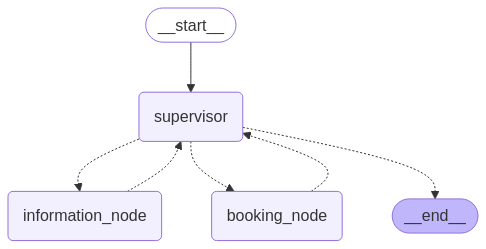

In [80]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [82]:
inputs = [
        HumanMessage(content='can you check and make a booking if general dentist available on 8 August 2024 at 8 PM?')
    ]
state = {'messages': inputs,'id_number':10232303}
result = app.invoke(state)
result["messages"][-1].content

************************** Below is my state right after entering ****************************
{'messages': [HumanMessage(content='can you check and make a booking if general dentist available on 8 August 2024 at 8 PM?', additional_kwargs={}, response_metadata={}, id='68f1ba6a-2b43-47aa-8464-c20528f3292d')], 'id_number': 10232303}
************************ This is my message ************************
[{'role': 'system', 'content': "You are a supervisor tasked with managing a conversation between following workers. ### SPECIALIZED ASSISTANT:\nWORKER: information_node \nDESCRIPTION: specialized agent to provide information related to availability of doctors or any FAQs related to hospital.\n\nWORKER: booking_node \nDESCRIPTION: specialized agent to only to book, cancel or reschedule appointment\n\nWORKER: FINISH \nDESCRIPTION: If User Query is answered and route to Finished\n\nYour primary role is to help the user make an appointment with the doctor and provide updates on FAQs and doctor's

NotImplementedError: 